In [9]:
import hashlib
from pathlib import Path

import arviz as az
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pymc_extras as pmx
import pytensor.tensor as pt
import scipy as sp
from astropy.table import Table
from astropy.visualization import quantity_support
from astroquery.gaia import Gaia

Gaia.MAIN_GAIA_TABLE = "gaiadr3.gaia_source"
quantity_support()

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x113f6c2d670>

In [2]:
ROOT = Path(".").resolve().parent
DATA_DIR = ROOT / "data"
output_dir = DATA_DIR / 'raw'
fields = [
    'source_id',
    'ra',
    'ra_error',
    'dec',
    'dec_error',
    'parallax',
    'parallax_error',
    'phot_g_n_obs',
    'phot_g_mean_flux',
    'phot_g_mean_flux_error',
    'phot_g_mean_mag',
    'phot_bp_n_obs',
    'phot_bp_mean_flux',
    'phot_bp_mean_flux_error',
    'phot_bp_mean_mag',
    'phot_rp_n_obs',
    'phot_rp_mean_flux',
    'phot_rp_mean_flux_error',
    'phot_rp_mean_mag',
]

In [3]:
job = Gaia.launch_job("SELECT vmag, b_v from public.hipparcos")
r = job.get_results()
# r.write('values.ecsv', overwrite=True)

In [4]:
def query_data(query: str):
    _hash = hashlib.md5(query.encode()).hexdigest()
    filename = f"GaiaQuery_{_hash}.ecsv"

    if (output_dir / filename).exists():
        return Table.read(output_dir / filename)

    job = Gaia.launch_job_async(query)
    job.get_results().write(output_dir / filename)
    return job.get_results()

In [5]:
results = query_data(
    """
    SELECT
        source_id,
        phot_g_mean_mag + 5.0 * log10(parallax) - 10.0 as g_mag_abs,
        bp_rp
    FROM gaiadr3.gaia_source_lite
    WHERE
        parallax_over_error >= 5
        AND phot_bp_mean_flux_over_error > 0
        AND phot_rp_mean_flux_over_error > 0
        AND SQRT(POWER(2.5/log(10) / phot_bp_mean_flux_over_error, 2) + POWER(2.5/log(10) / phot_rp_mean_flux_over_error, 2)) <= 0.05
        AND random_index BETWEEN 0 AND 10000000
    """
)

In [6]:
results = query_data(
    f"""
    SELECT {', '.join(fields)}
    FROM gaiadr3.gaia_source
    WHERE random_index BETWEEN 0 AND 10000000
    """
)

In [7]:
results["bp_rp"] = results["phot_bp_mean_mag"] - results["phot_rp_mean_mag"]
results["g_mag_abs"] = results["phot_g_mean_mag"] + 5.0 * np.log10(results["parallax"]) - 10.0

C:\Users\isaacm\AppData\Local\Temp\ipykernel_716\2571059971.py:2: RuntimeWarning: divide by zero encountered in log10
  results["g_mag_abs"] = results["phot_g_mean_mag"] + 5.0 * np.log10(results["parallax"]) - 10.0
C:\Users\isaacm\AppData\Local\Temp\ipykernel_716\2571059971.py:2: RuntimeWarning: invalid value encountered in log10
  results["g_mag_abs"] = results["phot_g_mean_mag"] + 5.0 * np.log10(results["parallax"]) - 10.0


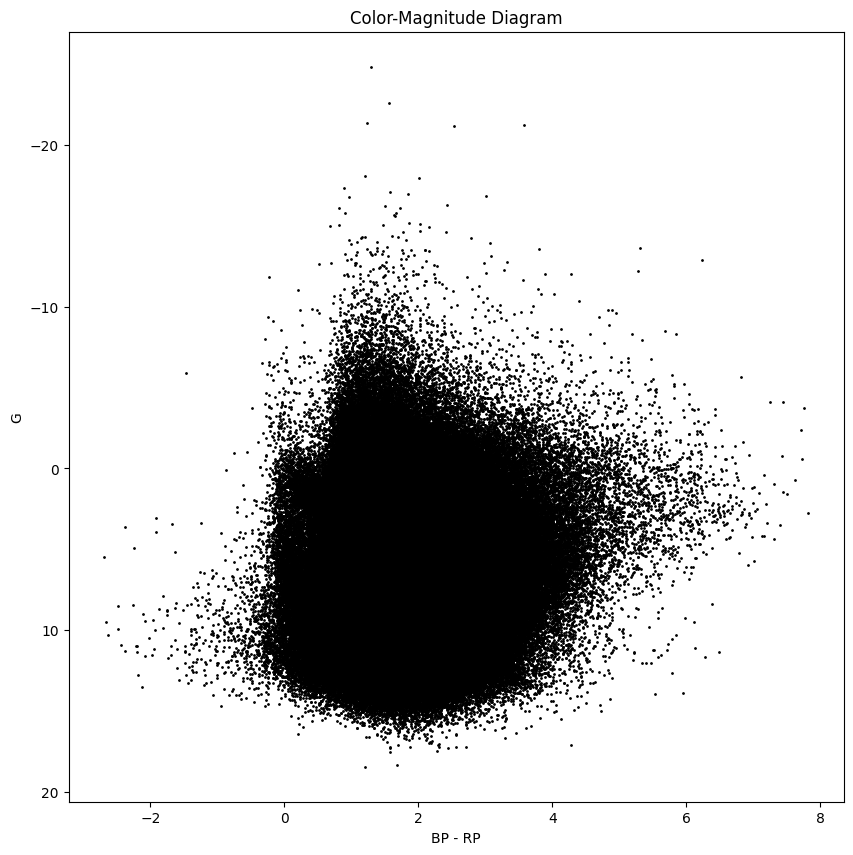

In [8]:
plt.figure(figsize=(10, 10))
plt.scatter(results["bp_rp"], results['g_mag_abs'], s=1, c='black')
plt.gca().invert_yaxis()
plt.xlabel('BP - RP')
plt.ylabel('G')
plt.title('Color-Magnitude Diagram')
plt.show()

In [9]:
def diagram_cm(color, mag):
    gammas = [0.8, 0.5, 0.3]

    fig, axs = plt.subplots(nrows=2, ncols=2)

    axs[0, 0].set_title('Linear normalization')
    axs[0, 0].hist2d(color, mag, bins=100)

    for ax, gamma in zip(axs.flat[1:], gammas):
        ax.set_title(r'Power law $(\gamma=%1.1f)$' % gamma)
        ax.hist2d(color, mag, bins=100, norm=mcolors.PowerNorm(gamma))

    fig.tight_layout()

    plt.show()

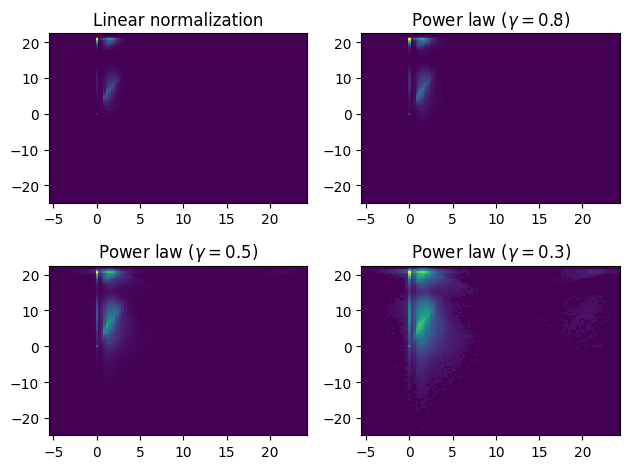

In [10]:
diagram_cm(results['bp_rp'], results['g_mag_abs'])

In [11]:
mu = 30
sig = 1

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [normal_dist]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


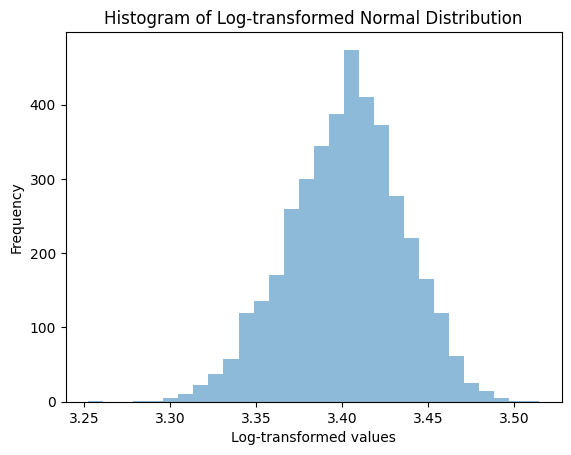

In [12]:
with pm.Model() as model:
    # Define the normal distribution
    normal_dist = pm.Normal('normal_dist', mu=mu, sigma=sig)
    
    # Apply the logarithmic transformation
    log_transform = pm.Deterministic('log_transform', pt.log(normal_dist))
    
    # Sample from the model
    trace = pm.sample(1000, return_inferencedata=False)

# Plot the transformed distribution
plt.hist(trace['log_transform'], bins=30, histtype="stepfilled", alpha=0.5)
plt.xlabel('Log-transformed values')
plt.ylabel('Frequency')
plt.title('Histogram of Log-transformed Normal Distribution')
plt.show()

In [5]:
import pytensor
from pathlib import Path
file = Path(pytensor.__file__).resolve().parent / 'misc/check_blas.py'
!python "$file"


        Some results that you can compare against. They were 10 executions
        of gemm in float64 with matrices of shape 2000x2000 (M=N=K=2000).
        All memory layout was in C order.

        CPU tested: Xeon E5345(2.33Ghz, 8M L2 cache, 1333Mhz FSB),
                    Xeon E5430(2.66Ghz, 12M L2 cache, 1333Mhz FSB),
                    Xeon E5450(3Ghz, 12M L2 cache, 1333Mhz FSB),
                    Xeon X5560(2.8Ghz, 12M L2 cache, hyper-threads?)
                    Core 2 E8500, Core i7 930(2.8Ghz, hyper-threads enabled),
                    Core i7 950(3.07GHz, hyper-threads enabled)
                    Xeon X5550(2.67GHz, 8M l2 cache?, hyper-threads enabled)


        Libraries tested:
            * numpy with ATLAS from distribution (FC9) package (1 thread)
            * manually compiled numpy and ATLAS with 2 threads
            * goto 1.26 with 1, 2, 4 and 8 threads
            * goto2 1.13 compiled with multiple threads enabled

                          Xeon   Xeon 

c:\Users\isaacm\myCode\estimacion-paralajes\.venv\Lib\site-packages\pytensor\link\c\cmodule.py:2959: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(


In [33]:
with model:
    idata = pmx.fit(method="pathfinder", num_draws=1000, inference_backend="blackjax")

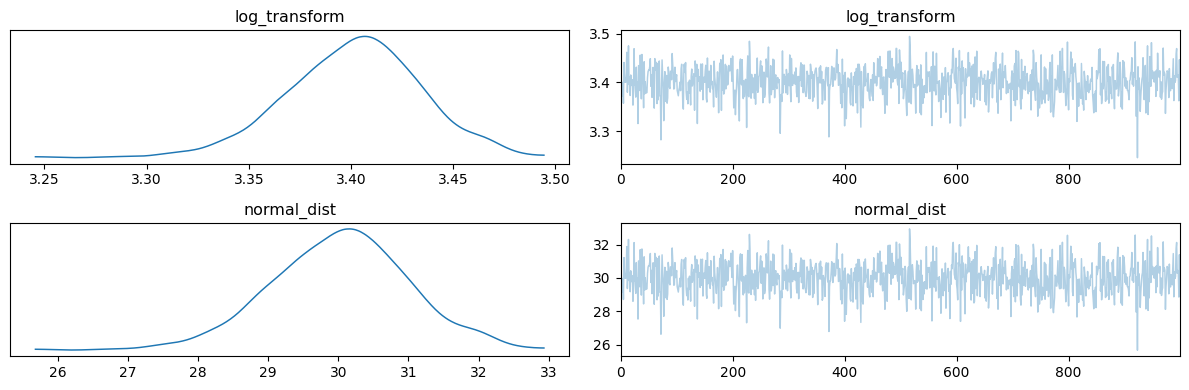

In [34]:
az.plot_trace(idata)
plt.tight_layout();

In [35]:
with model:
    idata = pmx.fit(method="pathfinder", num_draws=1000)

Output()

Pathfinder Results                         
                                           
  No. model parameters     1               
                                           
  Configuration:                           
  num_draws_per_path       1000            
  history size (maxcor)    5               
  max iterations           1000            
  ftol                     1.00e-05        
  gtol                     1.00e-08        
  max line search          1000            
  jitter                   2.0             
  epsilon                  1.00e-08        
  ELBO draws               10              
                                           
  LBFGS Status:                            
  CONVERGED                4               
  L-BFGS iterations        mean 3 ± std 0  
                                           
  Path Status:                             
  ELBO_ARGMAX_AT_ZERO      3               
  SUCCESS                  1               
  ELBO argmax              mean 0 ± std 0  
                                           
  Importance Sampling:                     
  Method                   psis            
  Pareto k                 0.25            
                                           
  Timing (seconds):                        
  Compile                  13.31           
  Compute                  0.22            
  Total                    13.53           

Warnings:
  - ELBO argmax at zero refers to the first iteration during LBFGS. A high occurrence suggests the model's         
  default initial point + jitter is may be too close to the mean posterior and a poor exploration of the           
  parameter space. Consider increasing jitter if this occurence is high relative to the number of paths.

C:\Users\isaacm\AppData\Local\Temp\ipykernel_7932\2614825100.py:2: UserWarning: The figure layout has changed to tight
  plt.tight_layout();


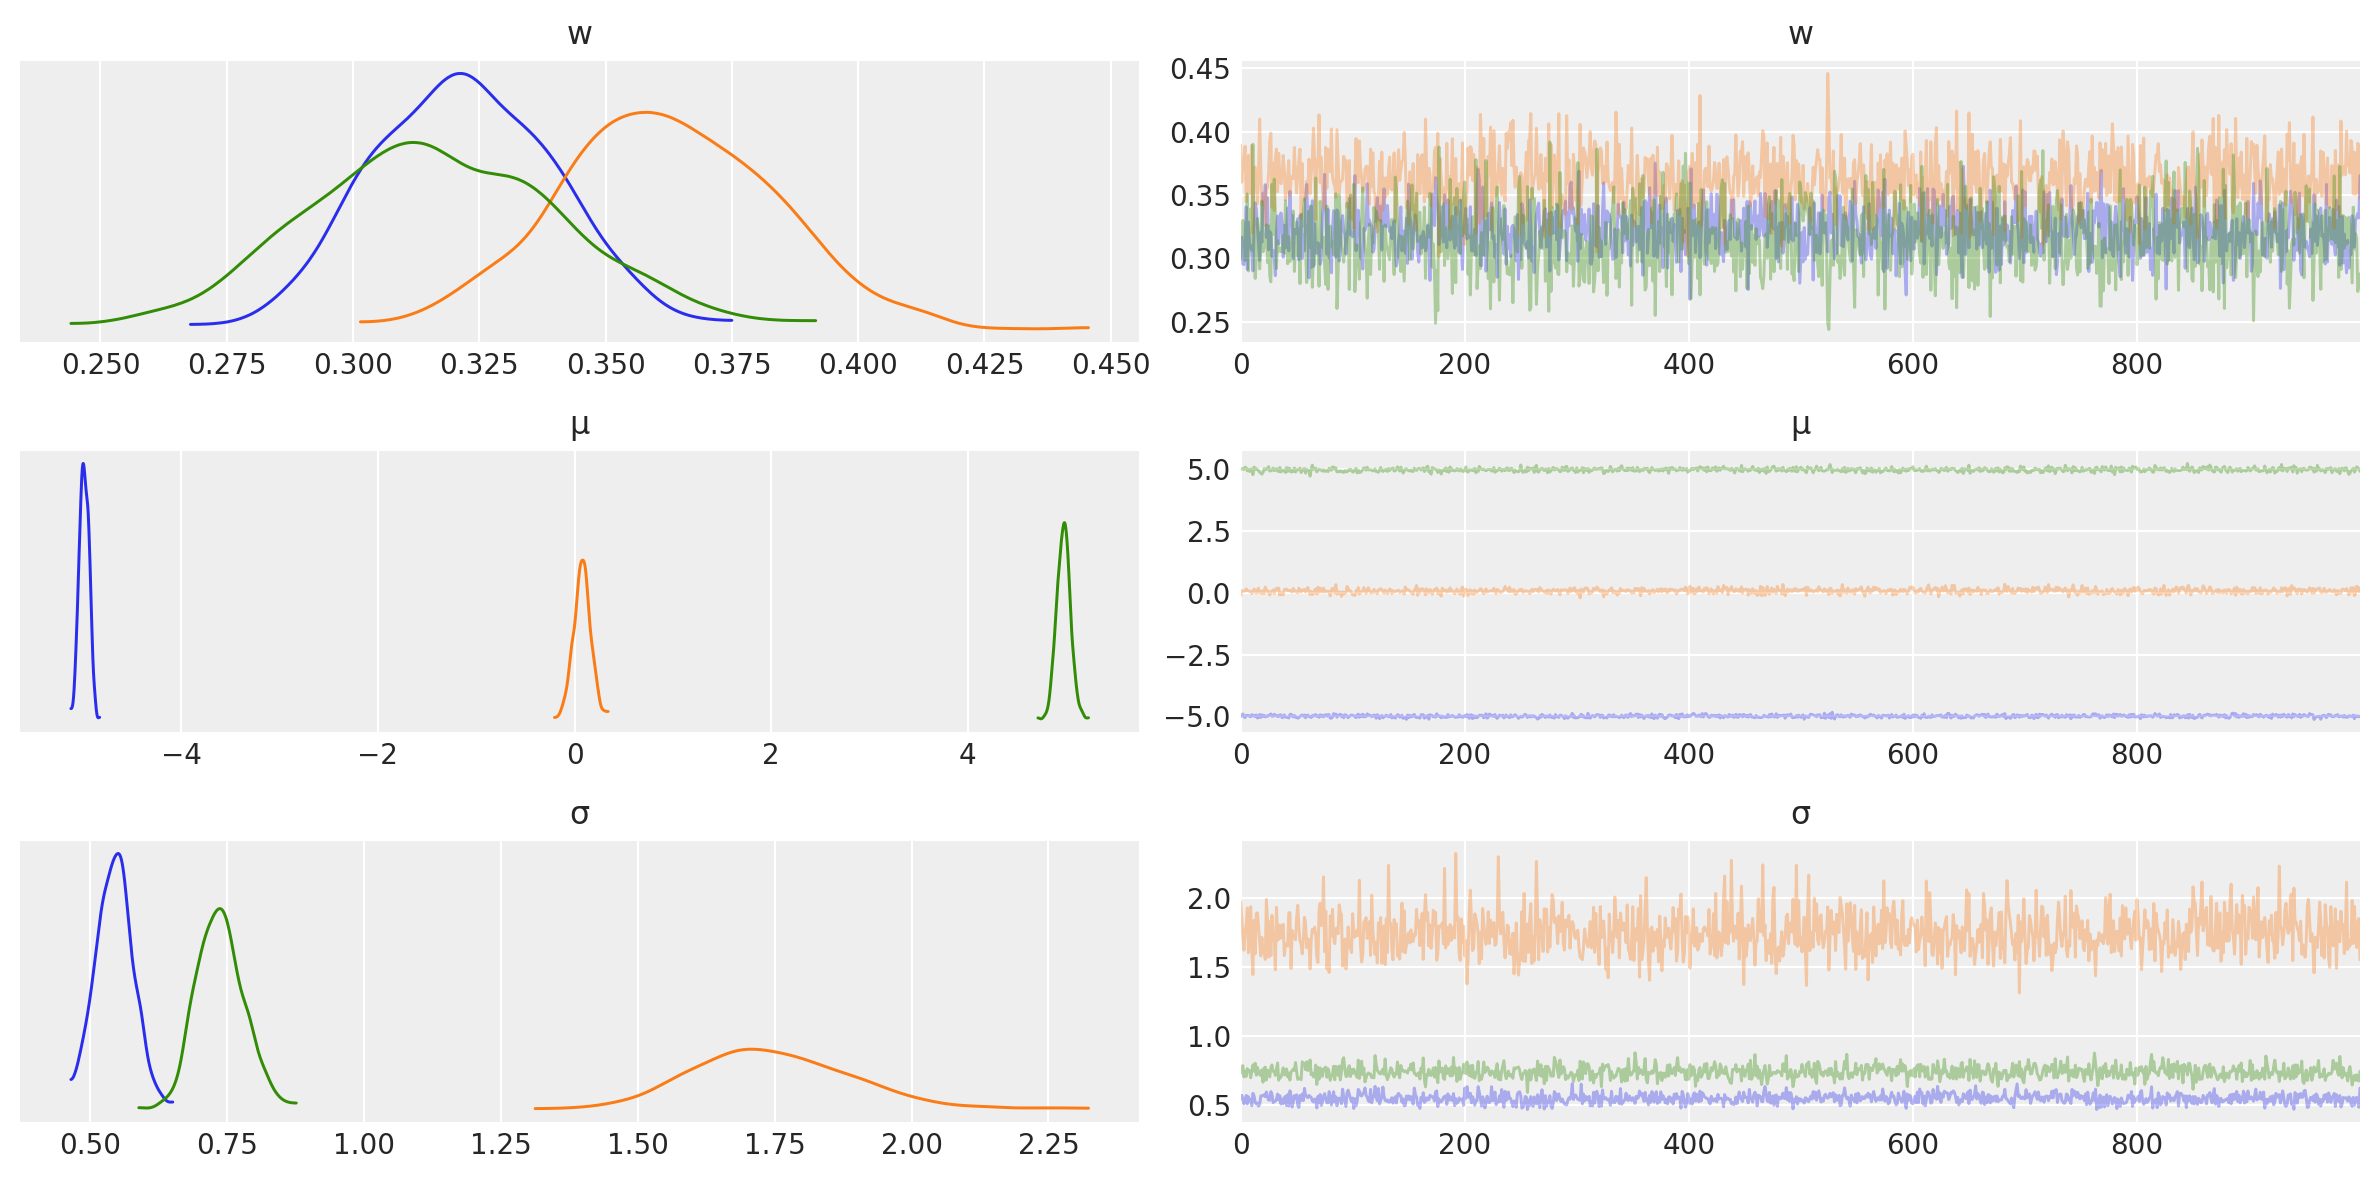

In [11]:
az.plot_trace(idata)
plt.tight_layout();

(array([14., 17., 36., 32., 29., 19., 13.,  3.,  3.,  0.,  4.,  8.,  4.,
         8., 10., 11., 13., 11., 13.,  8., 16., 11., 11., 12.,  6.,  4.,
         7.,  7.,  6.,  3.,  7., 15., 10., 21., 30., 25., 21., 18.,  8.,
         6.]),
 array([-6.09103153, -5.77452297, -5.4580144 , -5.14150583, -4.82499726,
        -4.50848869, -4.19198013, -3.87547156, -3.55896299, -3.24245442,
        -2.92594585, -2.60943729, -2.29292872, -1.97642015, -1.65991158,
        -1.34340301, -1.02689445, -0.71038588, -0.39387731, -0.07736874,
         0.23913983,  0.5556484 ,  0.87215696,  1.18866553,  1.5051741 ,
         1.82168267,  2.13819124,  2.4546998 ,  2.77120837,  3.08771694,
         3.40422551,  3.72073408,  4.03724264,  4.35375121,  4.67025978,
         4.98676835,  5.30327692,  5.61978548,  5.93629405,  6.25280262,
         6.56931119]),
 <BarContainer object of 40 artists>)

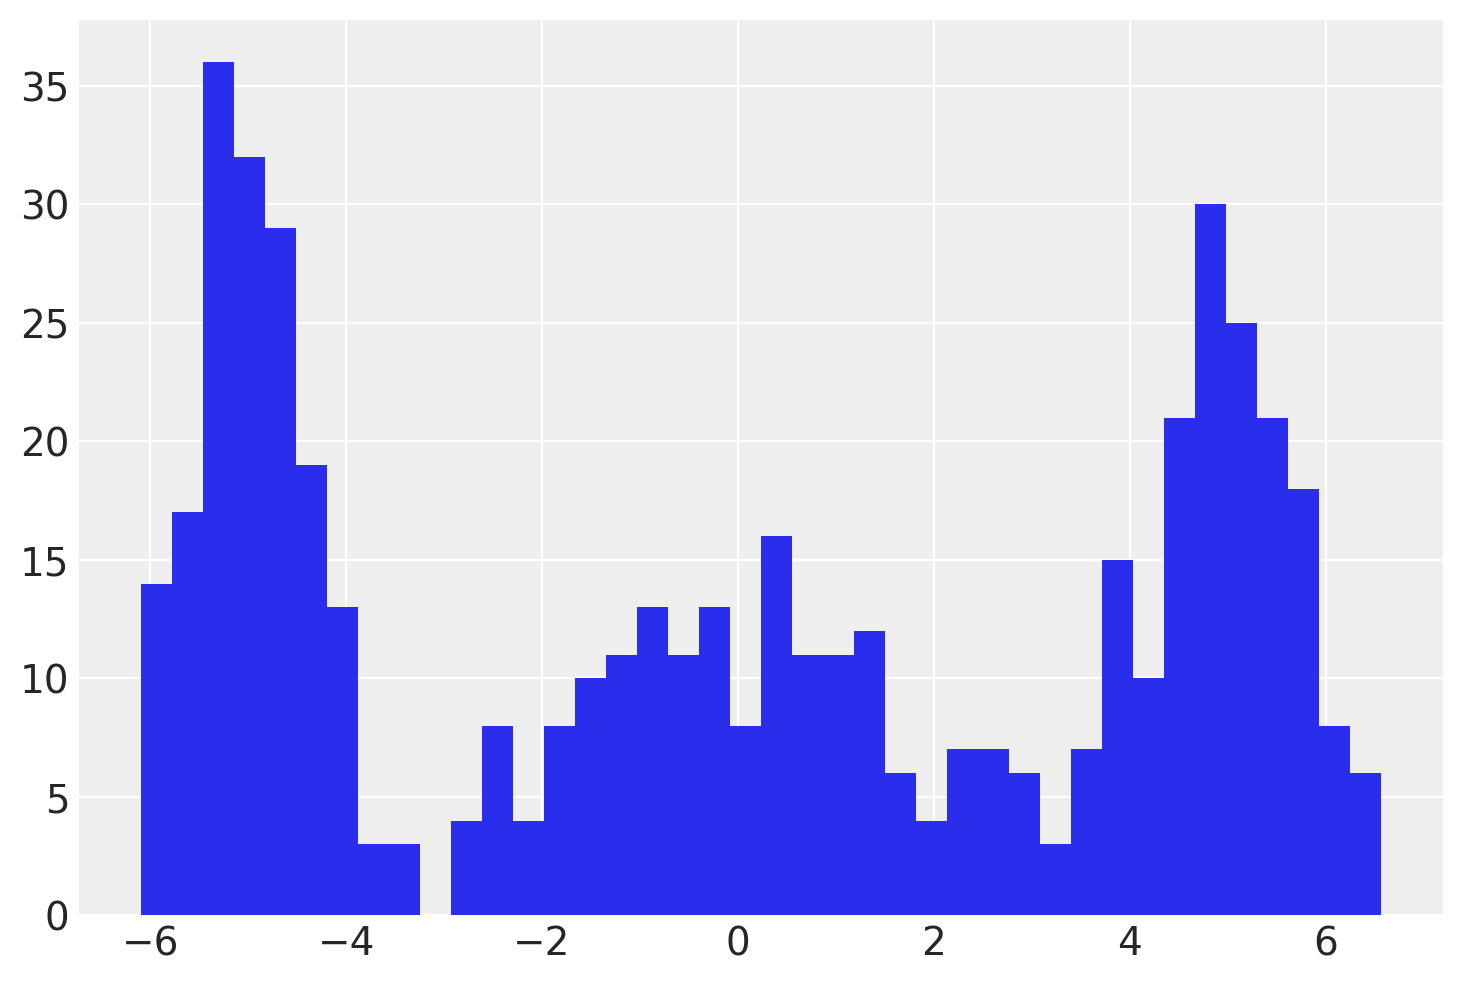

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from scipy.stats import norm
from xarray_einstats.stats import XrContinuousRV

%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

k = 3
ndata = 500
centers = np.array([-5, 0, 5])
sds = np.array([0.5, 2.0, 0.75])
idx = rng.integers(0, k, ndata)
x = rng.normal(loc=centers[idx], scale=sds[idx], size=ndata)
plt.hist(x, 40)

In [2]:
with pm.Model(coords={"cluster": range(k)}) as model:
    μ = pm.Normal(
        "μ",
        mu=0,
        sigma=5,
        transform=pm.distributions.transforms.ordered,
        initval=[-4, 0, 4],
        dims="cluster",
    )
    σ = pm.HalfNormal("σ", sigma=1, dims="cluster")
    weights = pm.Dirichlet("w", np.ones(k), dims="cluster")
    pm.NormalMixture("x", w=weights, mu=μ, sigma=σ, observed=x)

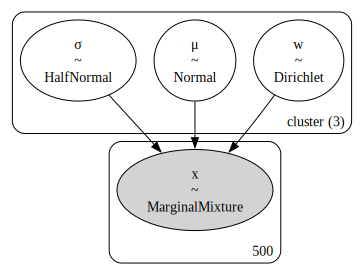

In [3]:
pm.model_to_graphviz(model)

In [10]:
with model:
    idata = pmx.fit(method="pathfinder", num_draws=1000, inference_backend="blackjax")

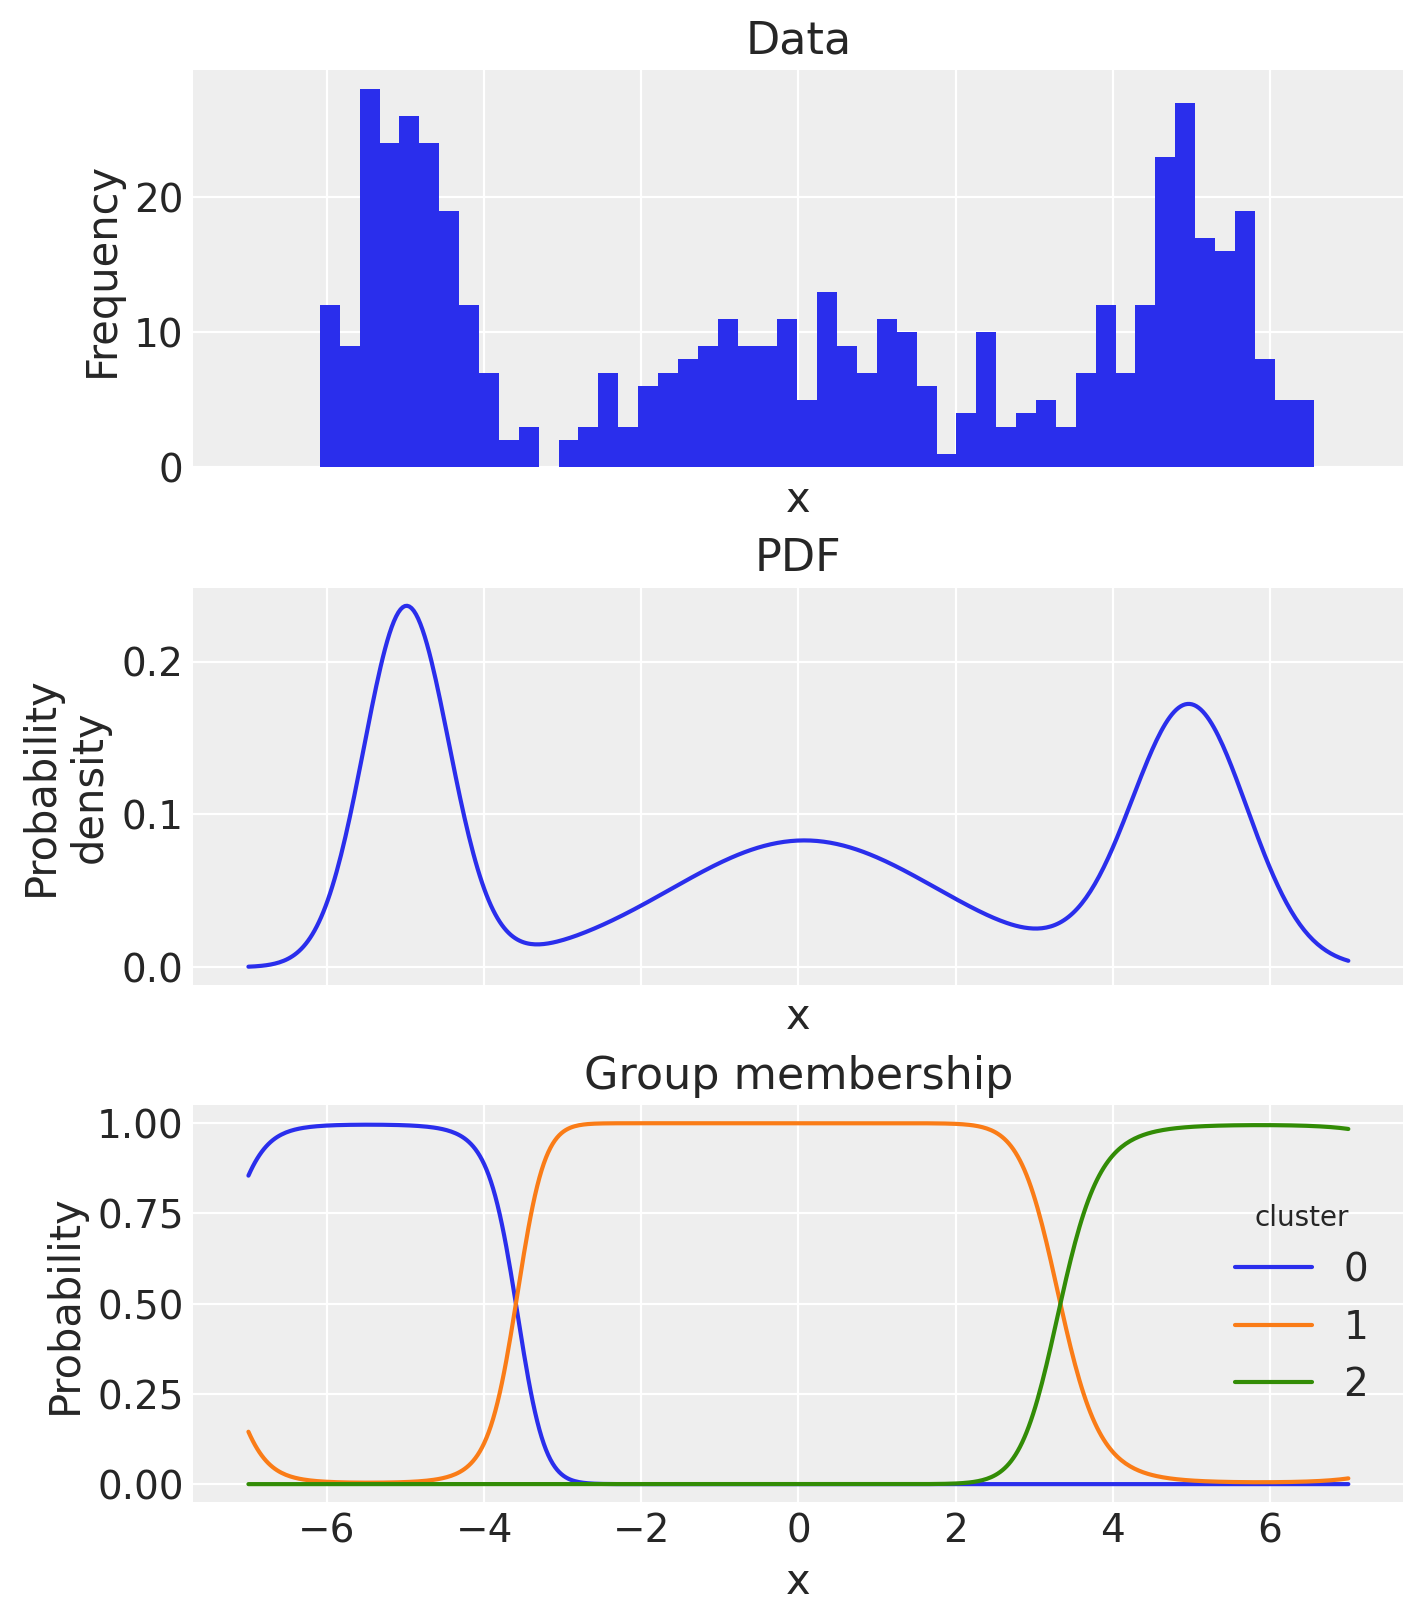

In [12]:
xi = np.linspace(-7, 7, 500)
post = idata.posterior
pdf_components = XrContinuousRV(norm, post["μ"], post["σ"]).pdf(xi) * post["w"]
pdf = pdf_components.sum("cluster")

fig, ax = plt.subplots(3, 1, figsize=(7, 8), sharex=True)
# empirical histogram
ax[0].hist(x, 50)
ax[0].set(title="Data", xlabel="x", ylabel="Frequency")
# pdf
pdf_components.mean(dim=["chain", "draw"]).sum("cluster").plot.line(ax=ax[1])
ax[1].set(title="PDF", xlabel="x", ylabel="Probability\ndensity")
# plot group membership probabilities
(pdf_components / pdf).mean(dim=["chain", "draw"]).plot.line(hue="cluster", ax=ax[2])
ax[2].set(title="Group membership", xlabel="x", ylabel="Probability");

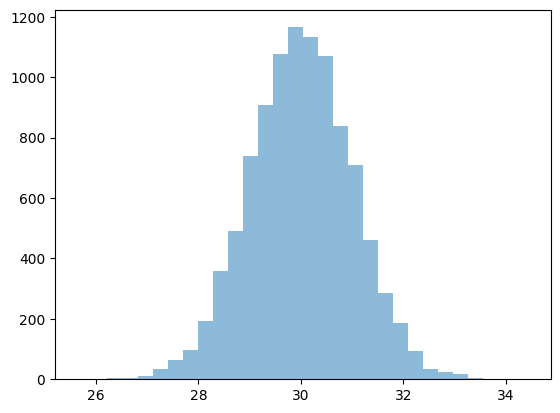

In [13]:
x = pm.draw(pm.Normal.dist(mu=mu, sigma=sig), 10000)
plt.hist(x, bins=30, histtype="stepfilled", alpha=0.5);

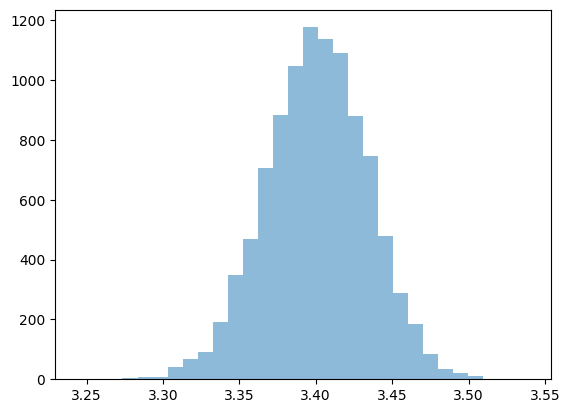

In [14]:
y = np.log(x)
plt.hist(y, bins=30, histtype="stepfilled", alpha=0.5);

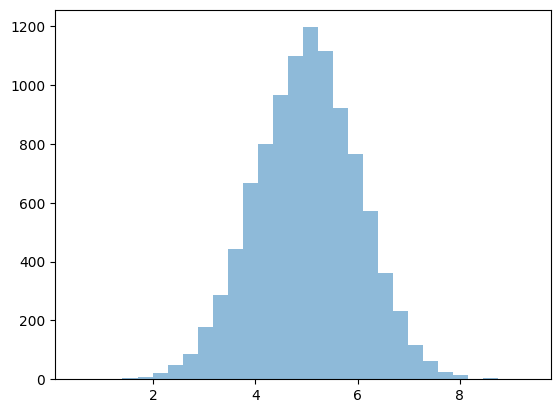

In [15]:
x = pm.draw(pm.Normal.dist(mu=5, sigma=1), 10000)
plt.hist(x, bins=30, histtype="stepfilled", alpha=0.5);

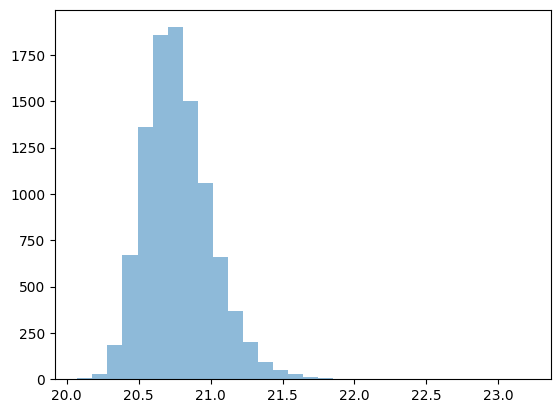

In [16]:
y = 22.5 -2.5*np.log10(x)
plt.hist(y, bins=30, histtype="stepfilled", alpha=0.5);

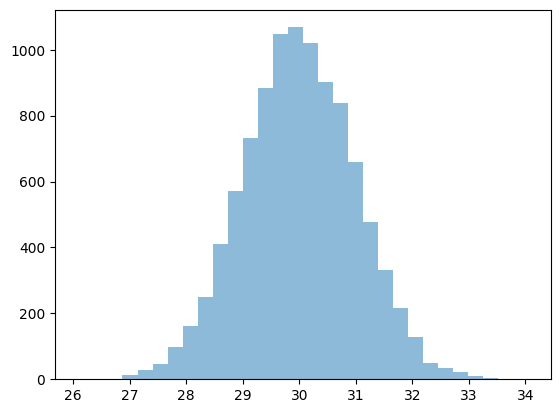

In [17]:
z = pm.draw(pm.TruncatedNormal.dist(mu=mu, sigma=sig, lower=0, upper=float("inf")), 10000)
plt.hist(z, bins=30, histtype="stepfilled", alpha=0.5);

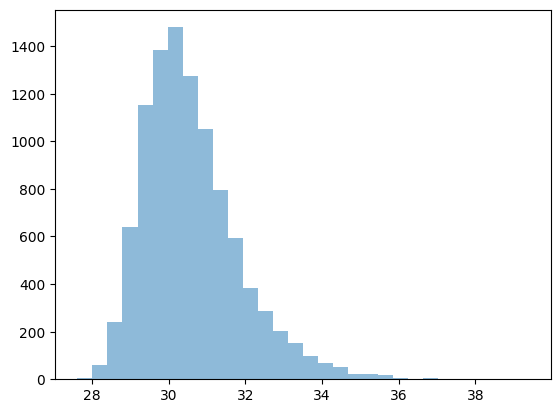

In [18]:
t = pm.draw(pm.Gumbel.dist(mu=mu, beta=sig), 10000)
plt.hist(t, bins=30, histtype="stepfilled", alpha=0.5);

<div>
<img src="https://www.cosmos.esa.int/documents/3414525/0/Logo_Gaia_may_23_2022.png/cf6be61e-609e-27dc-3ad6-03ac5209bdc4?t=1653299950248" width="300" align="right"/>    
</div>


# Cone search > Bulk download 

<br />
<br />
<br />
<br />
<br />


**Release number:** 
v1.1 (2022-08-06)


**Applicable Gaia Data Releases:**
Gaia EDR3, Gaia DR3

**Author:**
Héctor Cánovas Cabrera; hector.canovas@esa.int

**Summary:** 

This code computes the list of Gaia (E)DR3 files associated to a circular region in the sky defined by the user. The granularity of this region is set by the [HEALPix](https://healpix.sourceforge.io) level selected.

Input parameters:
* target catalogue (e.g., gaia_source, auxiliary/agn_cross_id, or auxiliary/frame_rotator_source),
* the cone-search parameters (centre and radius), and
* the desired healpix level.

Once the variables above are set the notebook creates a reference file that contains the min/max [HEALPix](https://healpix.sourceforge.io) index (levels: 6,7,8, and 9) encompassed by each gaia_source file available in the (E)DR3 [bulk download directory.](http://cdn.gea.esac.esa.int/Gaia/). The convertion between the different [HEALPix](https://healpix.sourceforge.io) levels is done by means of bit-shifting operations.


**Useful URLs:**

* [Questions or suggestions](https://www.cosmos.esa.int/web/gaia/questions)
* [Tutorials, documentation, and more](https://www.cosmos.esa.int/web/gaia-users/archive)
* [Known issues in the Gaia data](https://www.cosmos.esa.int/web/gaia-users/known-issues)
* [Gaia data credits and acknowledgements](https://www.cosmos.esa.int/web/gaia-users/credits)

In [22]:
import contextlib
import gzip
import io
from urllib.request import urlopen, urlretrieve

import numpy as np
import pandas as pd
from astropy import units as u
from astropy_healpix import HEALPix
from tqdm import tqdm


## Set input variables

Default input paramers:
* DR3 = True ; Default Value. Set it to False to retrieve EDR3 files
* target_table = 'gaia_source' ; Alternative values: 'Astrophysical_parameters/astrophysical_parameters', 'Variability/vari_cepheid', etc - see all the content in: http://cdn.gea.esac.esa.int/Gaia/gdr3/ & http://cdn.gea.esac.esa.int/Gaia/gedr3/
* Cone-search parameters: radius = 0.5 degrees, centred in the Large Magallanic Cloud (in ICRS coordinates).
* Healpix-level = 6 (choose a larger one to increase granularity, and viceversa).

In [23]:
# Set input parameters below ===========
DR3 = True  # Set it to False to select EDR3
target_table = 'gaia_source'  # Alternative values: 'Astrophysical_parameters/astrophysical_parameters/', etc
hpx_level = 6
lon = 80.894 * u.deg  # Right Ascencion (ICRS)
lat = -69.756 * u.deg  # Declination (ICRS)
radius = 0.5 * u.deg

print('Input Variables: ')
print(f'* HEALPix level                      = {hpx_level} ')
print(f'* ICRS longitude (~ Right Ascension) = {lon} ')
print(f'* ICRS latitude  (~ Declination)     = {lat} ')
print(f'* Radius                             = {radius} ')
print()

Input Variables: 
* HEALPix level                      = 6 
* ICRS longitude (~ Right Ascension) = 80.894 deg 
* ICRS latitude  (~ Declination)     = -69.756 deg 
* Radius                             = 0.5 deg 



## Create reference file

In [24]:
gaia_dr_flag = 'DR3' if DR3 else 'EDR3'

print('='*120)
print(f'Preparing selection of Gaia {gaia_dr_flag}: ""{target_table}" files')
print('='*120)

url_prefix = f'http://cdn.gea.esac.esa.int/Gaia/g{gaia_dr_flag.lower()}/{target_table}/'
md5sum_file_url = url_prefix + '_MD5SUM.txt'
md5sum_file = pd.read_csv(
    md5sum_file_url,
    header=None,
    sep=r'\s+',
    names=['md5Sum', 'file'],
)

if DR3:
    # The last row in the "_MD5SUM.txt" file in the DR3 directories includes the md5Sum value of the _MD5SUM.txt file
    md5sum_file.drop(md5sum_file.tail(1).index, inplace=True)

md5sum_file

Preparing selection of Gaia DR3: ""gaia_source" files


,md5Sum,file
0,52d800747f32a025bdcf1594bbbad29b,GaiaSource_000000-003111.csv.gz
1,aa91dfad8cc5122f109aacb462fb8304,GaiaSource_003112-005263.csv.gz
2,0ee8a887c3db8cb5110354c42289b0a2,GaiaSource_005264-006601.csv.gz
3,11ced35b2cead1950331222f6c5690f0,GaiaSource_006602-007952.csv.gz
4,b178d83fbe020b1f131c0aedcdc0cd29,GaiaSource_007953-010234.csv.gz
...,...,...
3381,20c69195b88742d586b0227d1831893a,GaiaSource_783518-784479.csv.gz
3382,bf8bf6562d676df85787a23e62a05b79,GaiaSource_784480-784992.csv.gz
3383,158b295db422e9d024b8f6c8429aaa9d,GaiaSource_784993-785417.csv.gz
3384,57c5737e81e2548ff0f1d57d7b667096,GaiaSource_785418-786096.csv.gz


In [25]:
# Extract HEALPix level-8 from file name ======================================
healpix_8_min  = [int(file[file.find('_')+1:file.rfind('-')])     for file in md5sum_file['file']]
healpix_8_max  = [int(file[file.rfind('-')+1:file.rfind('.csv')]) for file in md5sum_file['file']]
reference_file = pd.DataFrame({'file':md5sum_file['file'], 'healpix8_min':healpix_8_min, 'healpix8_max':healpix_8_max}).reset_index(drop=True)

# Compute HEALPix levels 6,7, and 9 ===========================================
reference_file['healpix7_min'] = [inp >> 2 for inp in reference_file['healpix8_min']]
reference_file['healpix7_max'] = [inp >> 2 for inp in reference_file['healpix8_max']]

reference_file['healpix6_min'] = [inp >> 2 for inp in reference_file['healpix7_min']]
reference_file['healpix6_max'] = [inp >> 2 for inp in reference_file['healpix7_max']]

reference_file['healpix9_min'] = [inp << 2       for inp in reference_file['healpix8_min']]
reference_file['healpix9_max'] = [(inp << 2) + 3 for inp in reference_file['healpix8_max']]

# Generate reference file =====================================================
ncols          = ['file', 'healpix6_min', 'healpix6_max', 'healpix7_min', 'healpix7_max', 'healpix8_min', 'healpix8_max', 'healpix9_min', 'healpix9_max']
reference_file = reference_file[ncols]
reference_file

,file,healpix6_min,healpix6_max,healpix7_min,healpix7_max,healpix8_min,healpix8_max,healpix9_min,healpix9_max
0,GaiaSource_000000-003111.csv.gz,0,194,0,777,0,3111,0,12447
1,GaiaSource_003112-005263.csv.gz,194,328,778,1315,3112,5263,12448,21055
2,GaiaSource_005264-006601.csv.gz,329,412,1316,1650,5264,6601,21056,26407
3,GaiaSource_006602-007952.csv.gz,412,497,1650,1988,6602,7952,26408,31811
4,GaiaSource_007953-010234.csv.gz,497,639,1988,2558,7953,10234,31812,40939
...,...,...,...,...,...,...,...,...,...
3381,GaiaSource_783518-784479.csv.gz,48969,49029,195879,196119,783518,784479,3134072,3137919
3382,GaiaSource_784480-784992.csv.gz,49030,49062,196120,196248,784480,784992,3137920,3139971
3383,GaiaSource_784993-785417.csv.gz,49062,49088,196248,196354,784993,785417,3139972,3141671
3384,GaiaSource_785418-786096.csv.gz,49088,49131,196354,196524,785418,786096,3141672,3144387


## Compute Healpix indexes associated to the selected  circular region

In [26]:
print('='*120)
print(f'Computing HEALPix Level {hpx_level} encompasing a Cone Search (Radius, longitude, latitude): {radius.value} {radius.unit},  {lon.value} {lon.unit}, {lat.value} {lat.unit}')
print('='*120)

hp = HEALPix(nside=2**hpx_level, order='nested')
hp_cone_search = hp.cone_search_lonlat(lon, lat, radius=radius)

Computing HEALPix Level 6 encompasing a Cone Search (Radius, longitude, latitude): 0.5 deg,  80.894 deg, -69.756 deg


## Download files

A .txt file with the list of files to be downloaded will be firts created. This file will be read and a secuencial download of all the files listed will start. A progress message will be in the terminal from where this Notebook was launched.

In [27]:
subset = []
for index in reference_file.index:
    row = reference_file.iloc[index]
    hp_min, hp_max = row[f'healpix{hpx_level}_min'], row[f'healpix{hpx_level}_max']
    if np.any(np.logical_and(hp_min <= hp_cone_search, hp_cone_search <= hp_max)):
        subset.append(url_prefix + row['file'])

print('='*120)
print(f'A total of {len(subset)} files for download')
print('='*120)

A total of 8 files for download


In [28]:
print("=" * 120)
print(f"Bulk download files are stored in directory: {output_dir}")
print("=" * 120)


class DownloadProgressBar(tqdm):
    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


def download_url(url: str):
    name = url.strip().split("/")[-1]
    filename = output_dir / name

    if filename.exists():
        statinfo = filename.stat()

        with contextlib.closing(urlopen(url)) as fp:
            headers = fp.info()
            length = int(headers["content-length"])

        if statinfo.st_size == length:
            print(f"Skipping {name}, file already downloaded")
            return
        else:
            print(f"Redownloading {name}")


    with DownloadProgressBar(
        unit="B",
        unit_scale=True,
        miniters=1,
        desc=name,
    ) as bar:
        urlretrieve(url, filename=filename, reporthook=bar.update_to)


for url in subset:
    download_url(url)


Bulk download files are stored in directory: C:\Users\isaacm\myCode\estimacion-paralajes\data\raw
Skipping GaiaSource_529516-529538.csv.gz, file already downloaded
Skipping GaiaSource_529539-529547.csv.gz, file already downloaded
Skipping GaiaSource_529548-529556.csv.gz, file already downloaded
Skipping GaiaSource_529557-529566.csv.gz, file already downloaded
Skipping GaiaSource_529567-529575.csv.gz, file already downloaded
Skipping GaiaSource_529576-529584.csv.gz, file already downloaded
Skipping GaiaSource_529585-529596.csv.gz, file already downloaded
Skipping GaiaSource_529597-529615.csv.gz, file already downloaded


In [29]:
def extract_header_table(filename, **kwargs):
    with gzip.open(filename, mode="rt", newline="") as file, io.BytesIO() as virtual:
        for line in file:
            virtual.write(line.encode())
            if not line.startswith("#"):
                break
        virtual.seek(0)
        return Table.read(
            virtual,
            format="ascii.ecsv",
            **kwargs,
        ).columns


columns = extract_header_table(
    next(output_dir.glob("*.csv.gz")),
    include_names=fields,
    fill_values=("null", "0"),
)

In [30]:
df = pd.concat(
    pd.read_csv(
        path,
        comment="#",
        index_col="source_id",
        usecols=fields,
        dtype={col: columns[col].dtype for col in columns},
    ) for path in output_dir.glob("*.csv.gz")
)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4250639 entries, 4657671992749548032 to 4658551572038462208
Data columns (total 18 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   ra                       float64
 1   ra_error                 float32
 2   dec                      float64
 3   dec_error                float32
 4   parallax                 float64
 5   parallax_error           float32
 6   phot_g_n_obs             int16  
 7   phot_g_mean_flux         float64
 8   phot_g_mean_flux_error   float32
 9   phot_g_mean_mag          float32
 10  phot_bp_n_obs            int16  
 11  phot_bp_mean_flux        float64
 12  phot_bp_mean_flux_error  float32
 13  phot_bp_mean_mag         float32
 14  phot_rp_n_obs            int16  
 15  phot_rp_mean_flux        float64
 16  phot_rp_mean_flux_error  float32
 17  phot_rp_mean_mag         float32
dtypes: float32(9), float64(6), int16(3)
memory usage: 397.3 MB


In [31]:
result = Table.from_pandas(
    df,
    units={
        col: columns[col].unit
        for col in columns
        if columns[col].unit
    },
)

In [32]:
df['g_mag_abs'] = df['phot_g_mean_mag'] + 5.0 * np.log10(df['parallax']) - 10.0
df['bp_rp'] = df['phot_bp_mean_mag'] - df['phot_rp_mean_mag']

c:\Users\isaacm\myCode\estimacion-paralajes\.venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [33]:
parallax = df['parallax'][~df['parallax'].isna()]
parallax.count(), parallax[parallax > 0].count()

(3285543, 1613359)

In [34]:
np.log10(parallax[parallax > 0])

source_id
4657671992749548032   -0.623164
4657671992751368448   -2.367496
4657671992752986368   -0.715131
4657671992773441536   -1.545002
4657671992773508224   -0.645278
                         ...   
4658551572035247104   -0.882658
4658551572035247744   -1.313709
4658551572035248768   -3.407298
4658551572035506560   -1.149724
4658551572035539584   -0.326718
Name: parallax, Length: 1613359, dtype: float64

In [35]:
pd.concat(
    [
        df['parallax'].isna().value_counts(),
        df['g_mag_abs'].isna().value_counts(),
    ],
    axis=1,
    keys=["parallax", "g_mag_abs"],
)

,parallax,g_mag_abs
False,3285543,1611537
True,965096,2639102


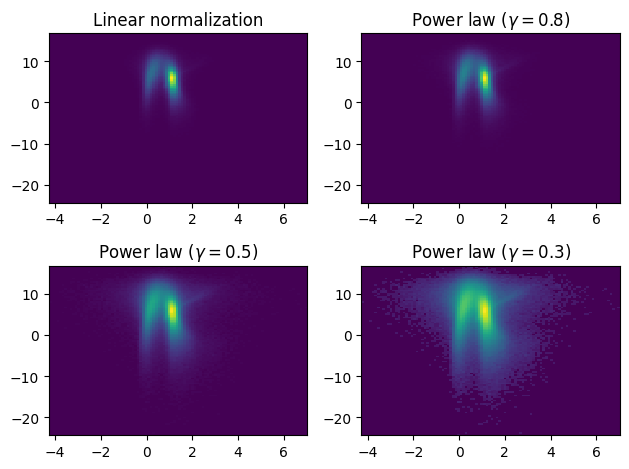

In [36]:
odf = df.dropna(subset=['bp_rp', 'g_mag_abs'])
diagram_cm(
    odf['phot_bp_mean_mag'] - odf['phot_rp_mean_mag'],
    odf['g_mag_abs'],
)

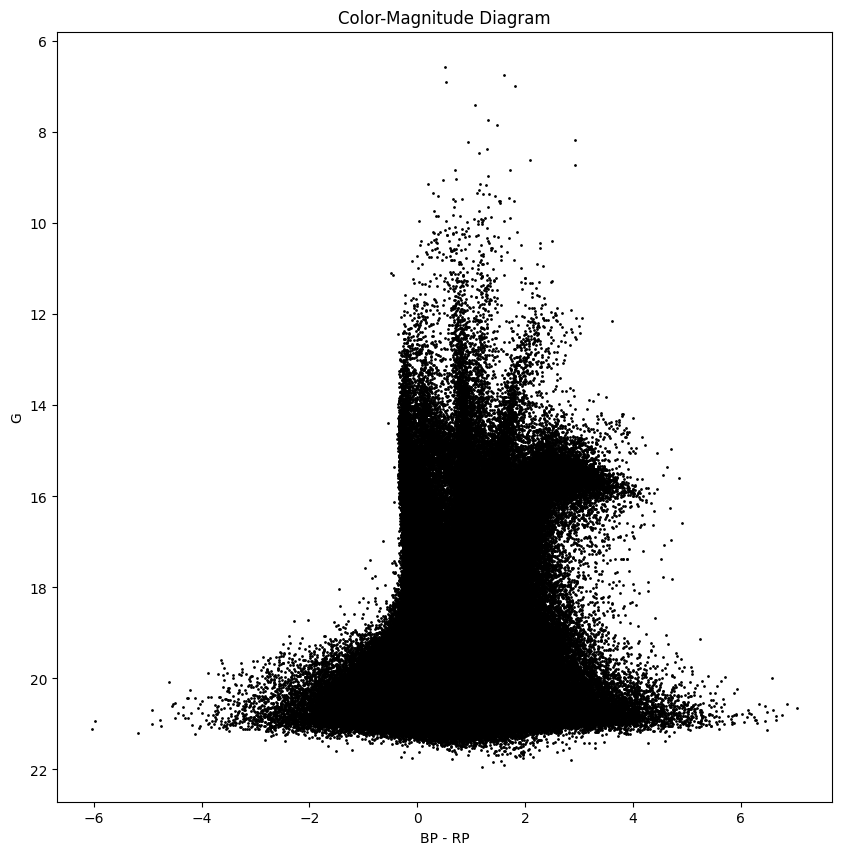

In [37]:
plt.figure(figsize=(10, 10))
plt.scatter(df['phot_bp_mean_mag'] - df['phot_rp_mean_mag'], df['phot_g_mean_mag'], s=1, c='black')
plt.gca().invert_yaxis()
plt.xlabel('BP - RP')
plt.ylabel('G')
plt.title('Color-Magnitude Diagram')
plt.show()